# Utilizando modelos YOLO-V5 com OpenCV em formato Open Neural Network Exchange (ONNX)

In [5]:
import cv2
import time
import sys
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

## Convertendo um modelo Pytorch em formato ONNX

In [2]:
#git clone https://github.com/ultralytics/yolov5
#cd yolov5
#pip install -r yolov5/requirements.txt
#EXIGE TORCH PARA CUDA 11.8

Baixando o peso do YoloV5-X (Pode ser qualquer outro)

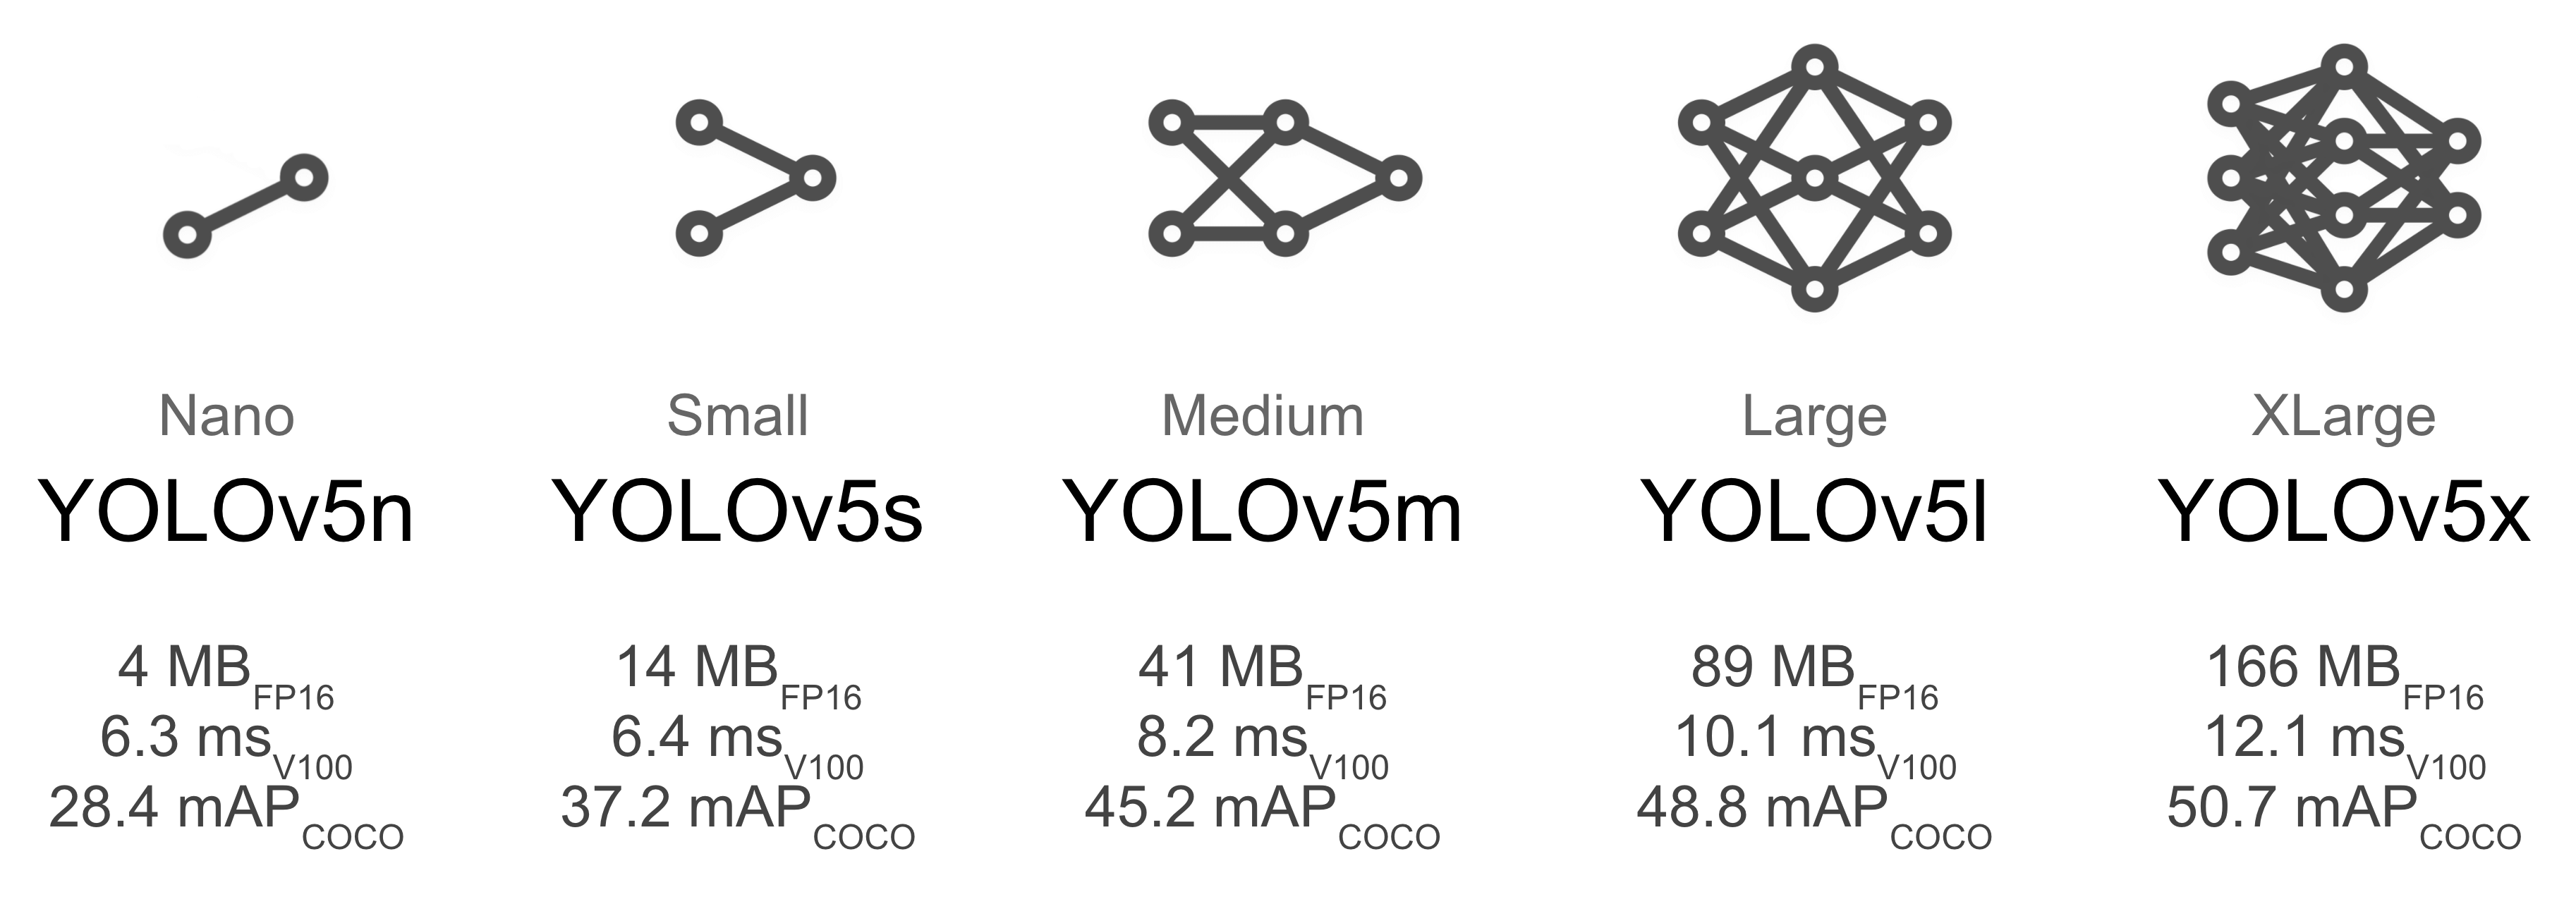

In [3]:
#!wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5x6.pt

Convertendo o peso em formato Pytorch para ONNX.

In [4]:
#!python yolov5/export.py --weights yolov5x6.pt --include onnx --opset 12

#OU COM GPU LOCALMENTE E SIMPLIFICADO
#python yolov5/export.py --weights yolov5x.pt --include onnx --opset 12 --device 0 --simplify

## Detectando objetos

In [6]:
def imshow(titulo = 'Imagem', imagem = None, size = 10):
    w, h = imagem.shape[0], imagem.shape[1]
    aspect = w/h
    plt.Figure(figsize=(size * aspect, size))
    plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.show()

Running on CPU


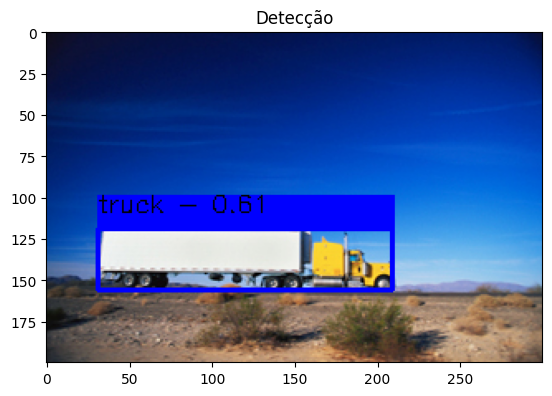

In [6]:

#Constantes necessárias

INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.2
NMS_THRESHOLD = 0.4
CONFIDENCE_THRESHOLD = 0.4

#Função que carrega o modelo neural, e em seguida, define o back-end que irá ser executado.
#CPU ou GPU
#Retorna a rede em si.
def build_model():
    net = cv2.dnn.readNet("yolov5x.onnx")
    #USANDO GPU com CUDA
    #print("Running on CUDA")
    #net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    #net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    #USANDO CPU padrão

    print("Running on CPU")
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    return net

#Função que passa o frame para uma função de transformação em arquivo BLOB
# (Binary Large Object) que contém informações de imagem ou vídeo.
#Insere o blob na rede.
# a Rede retorna as predições.
def detect(image, net):
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
    net.setInput(blob)
    preds = net.forward()
    return preds

#Função que carrega a imagem.
def load_image():
    image = cv2.imread("imagens/truck.jpg")
    return image

#Função que retorna as classes COCO do arquivo txt
def load_classes():
    class_list = []
    with open("coco.txt", "r") as f:
        class_list = [cname.strip() for cname in f.readlines()]
    return class_list

class_list = load_classes()

#Função que gera os Bounding boxes, a classe e as confianças
def wrap_detection(input_image, output_data):
    class_ids = []  # Inicializa uma lista vazia para armazenar as IDs das classes detetadas
    confidences = []  # Inicializa uma lista vazia para armazenar as confianças das deteções
    boxes = []  # Inicializa uma lista vazia para armazenar os bounding boxes das deteções

    rows = output_data.shape[0]  # Obtém o número de linhas (detecções) nos dados de saída

    image_width, image_height, _ = input_image.shape  # Obtém a largura e a altura da imagem de entrada

    x_factor = image_width / INPUT_WIDTH  # Calcula o fator de escala para a largura da imagem
    y_factor =  image_height / INPUT_HEIGHT  # Calcula o fator de escala para a altura da imagem

    for r in range(rows):  # Itera sobre cada linha (detecção) nos dados de saída
        row = output_data[r]  # Obtém a linha atual
        confidence = row[4]  # Obtém a confiança da detecção
        if confidence >= 0.4:  # Verifica se a confiança é maior ou igual a 0.4

            classes_scores = row[5:]  # Obtém as pontuações das classes a partir da sexta coluna
            _, _, _, max_indx = cv2.minMaxLoc(classes_scores)  # Obtém o índice da classe com a pontuação máxima
            class_id = max_indx[1]  # Obtém a ID da classe com a pontuação máxima
            if (classes_scores[class_id] > .25):  # Verifica se a pontuação da classe máxima é maior que 0.25

                confidences.append(confidence)  # Adiciona a confiança à lista de confianças
                class_ids.append(class_id)  # Adiciona a ID da classe à lista de IDs das classes

                x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item()  # Obtém as coordenadas e dimensões do bounding box
                left = int((x - 0.5 * w) * x_factor)  # Calcula a coordenada x do canto superior esquerdo do bounding box
                top = int((y - 0.5 * h) * y_factor)  # Calcula a coordenada y do canto superior esquerdo do bounding box
                width = int(w * x_factor)  # Calcula a largura do bounding box
                height = int(h * y_factor)  # Calcula a altura do bounding box
                box = np.array([left, top, width, height])  # Cria um array com as coordenadas e dimensões do bounding box
                boxes.append(box)  # Adiciona o bounding box à lista de bounding boxes

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.25, 0.45)  # Aplica a supressão de não-máximos (NMS) aos bounding boxes

    result_class_ids = []  # Inicializa uma lista para armazenar as IDs das classes resultantes após o NMS
    result_confidences = []  # Inicializa uma lista para armazenar as confianças resultantes após o NMS
    result_boxes = []  # Inicializa uma lista para armazenar os bounding boxes resultantes após o NMS

    for i in indexes:  # Itera sobre os índices resultantes do NMS
        result_confidences.append(confidences[i])  # Adiciona a confiança correspondente à lista de confianças resultantes
        result_class_ids.append(class_ids[i])  # Adiciona a ID da classe correspondente à lista de IDs das classes resultantes
        result_boxes.append(boxes[i])  # Adiciona o bounding box correspondente à lista de bounding boxes resultantes

    return result_class_ids, result_confidences, result_boxes  # Retorna as IDs das classes, as confianças e os bounding boxes resultantes

def format_yolov5(frame):
    row, col, _ = frame.shape  # Obtém as dimensões (linhas, colunas e canais) da imagem de entrada
    _max = max(col, row)  # Calcula o tamanho máximo entre as dimensões da imagem
    result = np.zeros((_max, _max, 3), np.uint8)  # Cria uma matriz de zeros com as dimensões máximas e 3 canais de cor
    result[0:row, 0:col] = frame  # Copia a imagem de entrada para a parte superior esquerda da matriz resultante
    return result  # Retorna a imagem resultante com dimensões quadradas

colors = [(255, 255, 0), (0, 255, 0), (0, 255, 255), (255, 0, 0)]

net = build_model()
image = load_image()

inputImage = format_yolov5(image)
outs = detect(inputImage, net)

class_ids, confidences, boxes = wrap_detection(inputImage, outs[0])


for (classid, confidence, box) in zip(class_ids, confidences, boxes):
    color = colors[int(classid) % len(colors)]
    cv2.rectangle(image, box, color, 2)
    cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)
    cv2.putText(image, class_list[classid] + f" - {confidence:.2}"  , (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))


imshow("Detecção",image)


## YoloV5 em vídeos, com mecanismo nativo do framework

### No YoloV5, os resultados das execuções são armazenadas na pasta yolov5/runs/detect/exp

Alguns parâmetros de execução:


data = Onde está as classes

imgsz = tamanho de entrada de frame

conf_thres = Threhold mínimo de confiança

iou_thres = Threhold mínimo de confiança da intersecção das BB

max_det = máximo de detecções

device = 0 (GPU com CUDA)




In [4]:
#Detectando imagens automaticamente

!python yolov5/detect.py --weights yolov5x.pt --source imagens/truck.jpg --data yolov5/data/coco128.yaml

#PEGAR DO YOUTUBE A ULR DO VIDEO E NAO DO NAVEGADOR
!python yolov5/detect.py --weights yolov5x.pt --source ../../videos/RodoviaCOREIA.mp4 --data yolov5/data/coco128.yaml


detect: weights=['yolov5x.pt'], source=imagens/truck.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-398-g5cdad892 Python-3.13.1 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 8192MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
image 1/1 C:\Repositorios\ClassicalCV\ProjetosOPENCV\YoloV5V7V8\imagens\truck.jpg: 448x640 1 truck, 37.2ms
Speed: 0.4ms pre-process, 37.2ms inference, 51.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5\runs\detect\exp3
detect: weights=['yolov5x.pt'], source=../../videos/RodoviaCOREIA.m

# Utilizando modelos YOLO-V7 com Framework

In [11]:
!git clone https://github.com/WongKinYiu/yolov7

fatal: destination path 'yolov7' already exists and is not an empty directory.


In [12]:
#BAIXAR https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Detectando imagem com YoloV7

In [2]:
#Detectando imagem
# PARA RODAR NA MAQUINA LOCAL, alterar no arquivo serialization.py, na função, LOAD do pytorch, o atributo weights_only: Optional[bool] = False,
!python yolov7/detect.py --weights yolov7-w6.pt --conf 0.25 --img-size 640 --source imagens/truck.jpg

Namespace(weights=['yolov7-w6.pt'], source='imagens/truck.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 truck, Done. (14.4ms) Inference, (79.1ms) NMS
 The image with the result is saved in: runs\detect\exp2\truck.jpg
Done. (0.262s)


YOLOR  v0.1-128-ga207844 torch 2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 8191.5MB)

c:\Anaconda\envs\yolov578\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 343 layers, 70394300 parameters, 653820 gradients, 89.9 GFLOPS


## Detectando vídeo com YoloV7

In [3]:
#Detectando vídeo

!python yolov7/detect.py --weights yolov7-w6.pt --conf 0.25 --img-size 640 --source ../../videos/RodoviaCOREIA.mp4 --name videoCarrosV7

Namespace(weights=['yolov7-w6.pt'], source='../../videos/RodoviaCOREIA.mp4', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='videoCarrosV7', exist_ok=False, no_trace=False)
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

video 1/1 (1/776) c:\Repositorios\ClassicalCV\ProjetosOPENCV\YoloV5V7V8\..\..\videos\RodoviaCOREIA.mp4: 14 cars, 5 trucks, Done. (10.9ms) Inference, (66.9ms) NMS
video 1/1 (2/776) c:\Repositorios\ClassicalCV\ProjetosOPENCV\YoloV5V7V8\..\..\videos\RodoviaCOREIA.mp4: 13 cars, 4 trucks, Done. (10.6ms) Inference, (1.7ms) NMS
video 1/1 (3/776) c:\Repositorios\ClassicalCV\ProjetosOPENCV\YoloV5V7V8\..\..\videos\RodoviaCOREIA.mp4: 12 cars, 2 trucks, Done. (12.8ms) Inference, (1.0ms) NMS
video 1/1 (4/776) c:\Repositorios\ClassicalCV\ProjetosOPENCV\YoloV5V7V8\..\

YOLOR  v0.1-128-ga207844 torch 2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 8191.5MB)

c:\Anaconda\envs\yolov578\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 343 layers, 70394300 parameters, 653820 gradients, 89.9 GFLOPS


# Utilizando modelos YOLO-V8 com Biblioteca via PIP

In [1]:
!pip install ultralytics

In [2]:
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

model = YOLO('yolov8x.pt')

## Detectando imagem com YoloV8


image 1/1 c:\Repositorios\ClassicalCV\ProjetosOPENCV\YoloV5V7V8\imagens\truck.jpg: 448x640 1 truck, 41.6ms
Speed: 3.2ms preprocess, 41.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


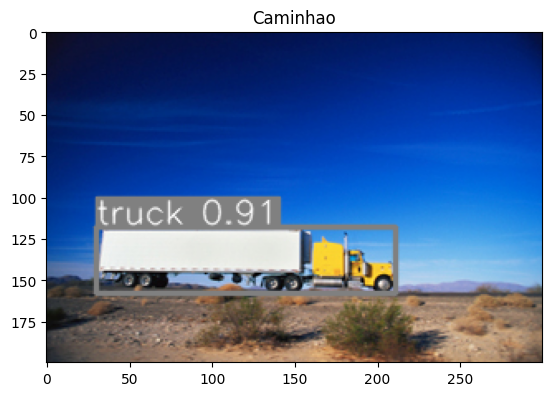

In [7]:
results = model('imagens/truck.jpg')
img = cv2.imread('imagens/truck.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
annotator = Annotator(img)
for r in results:
    for box in r.boxes:
        b = box.xyxy[0]
        c = box.cls
        annotator.box_label(b, f"{r.names[int(c)]} {float(box.conf):.2}")

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
imshow("Caminhao", img)


## Detectando vídeo com YoloV8

In [8]:
def processar_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)  # Inicialize a captura do vídeo

    # Verifique se a captura foi inicializada corretamente
    if not cap.isOpened():
        print("Erro ao abrir o vídeo")
        return

    # Crie o vídeo de saída com as mesmas configurações do vídeo de entrada
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    # Processar cada frame do vídeo
    while cap.isOpened():
        ret, frame = cap.read()  # Captura o próximo frame do vídeo

        if not ret:
            break  # Se não houver mais frames, saia do loop

        results = model(frame)  # Aplica o modelo de detecção de objetos ao frame atual
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converte o frame para o formato RGB
        annotator = Annotator(img_rgb)

        # Desenhe os bounding boxes e etiquetas sobre o frame
        for r in results:
            for box in r.boxes:
                b = box.xyxy[0]
                c = box.cls
                annotator.box_label(b, f"{r.names[int(c)]} {float(box.conf):.2}")


        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)  # Converte o frame de volta para o formato BGR
        out.write(img_bgr)  # Escreve o frame processado no vídeo de saída

    cap.release()  # Libera o vídeo de entrada
    out.release()  # Libera o vídeo de saída
    cv2.destroyAllWindows()  # Fecha todas as janelas abertas

# Chame a função para processar o vídeo
processar_video('../../videos/RodoviaCOREIA.mp4', 'videoCarros_saidaV8.mp4')



0: 384x640 13 cars, 4 trucks, 49.4ms
Speed: 1.6ms preprocess, 49.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 4 trucks, 35.6ms
Speed: 1.2ms preprocess, 35.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 4 trucks, 37.7ms
Speed: 1.0ms preprocess, 37.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 2 trucks, 35.6ms
Speed: 1.1ms preprocess, 35.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 2 trucks, 31.3ms
Speed: 0.8ms preprocess, 31.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 2 trucks, 32.4ms
Speed: 1.0ms preprocess, 32.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 cars, 1 truck, 30.4ms
Speed: 0.7ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 cars, 2 trucks, 31.4ms
Speed: 0.9ms prepr

## Para o treinamento de um modelo personalizado com seu Dataset. Realize a coleta de imagens e rotule conforme o formato correto e organize as pastas com o padrão estipulado pelo YoloV8. Mais detalhes do processo, acesso o link abaixo:

[Link do tutorial](https://www.freecodecamp.org/news/how-to-detect-objects-in-images-using-yolov8/)